<a href="https://colab.research.google.com/github/MehmedBucket03/CSC467Mod03Assignment/blob/main/Module03Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving cameraman.jpg to cameraman.jpg


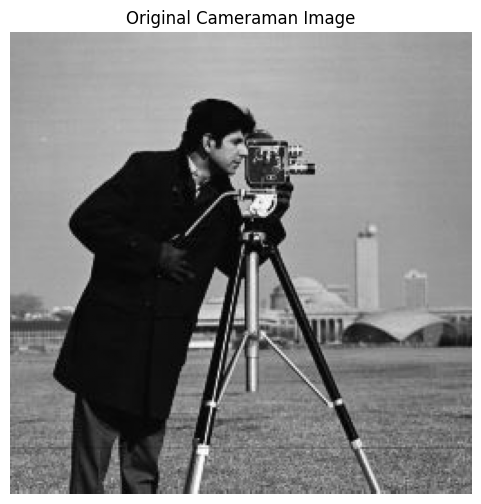

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]
cameraman = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(cameraman, cmap='gray')
plt.title('Original Cameraman Image')
plt.axis('off')
plt.show()

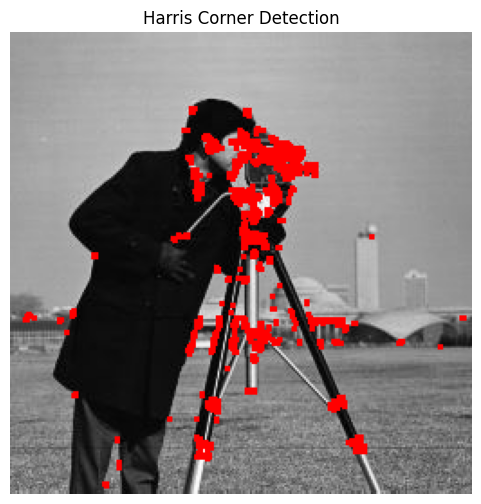

In [5]:
### Part A: Harris Corner Detector ###
#converting to float is best for preciseness
#then dialate harris response for the corner points and threshold


def harris_corner_detector(img):
    gray = np.float32(img)

    harris_response = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_response = cv2.dilate(harris_response, None)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    threshold = 0.01 * harris_response.max()
    img_color[harris_response > threshold] = [0, 0, 255]

    return img_color

harris_image = harris_corner_detector(cameraman)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(harris_image, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.axis('off')
plt.show()


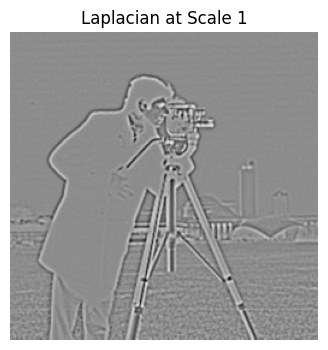

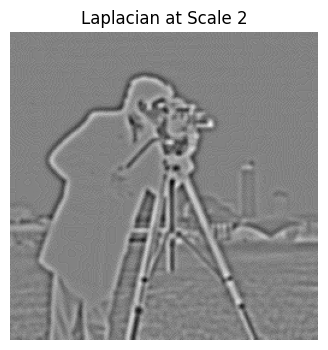

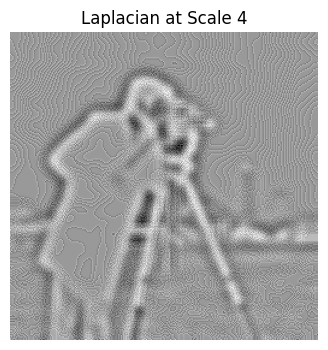

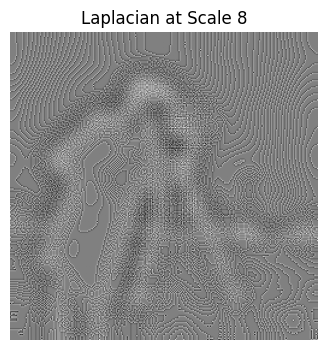

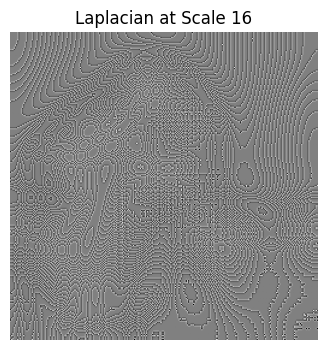

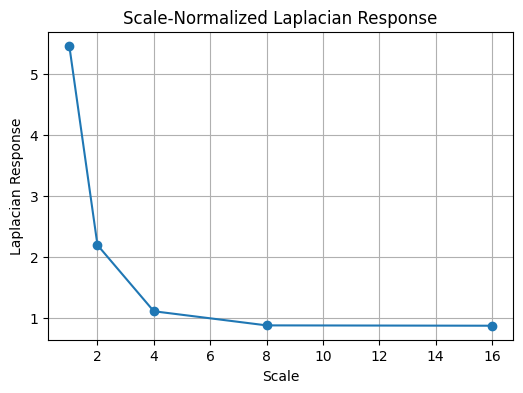

In [3]:
### Part B: Scale Invariance (Laplacian & DoG) ###
#using gaussian blur and computing laplacian, then display lap at each scale
#plotted to graph to show how steep the drop is

def scale_invariance_analysis(img):
    scales = [1, 2, 4, 8, 16]
    laplacian_responses = []

    for s in scales:
        blurred = cv2.GaussianBlur(img, (0, 0), sigmaX=s, sigmaY=s)
        laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
        normalized_laplacian = np.abs(laplacian).mean()
        laplacian_responses.append(normalized_laplacian)

        plt.figure(figsize=(4, 4))
        plt.imshow(laplacian, cmap='gray')
        plt.title(f'Laplacian at Scale {s}')
        plt.axis('off')
        plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(scales, laplacian_responses, marker='o')
    plt.xlabel('Scale')
    plt.ylabel('Laplacian Response')
    plt.title('Scale-Normalized Laplacian Response')
    plt.grid()
    plt.show()

scale_invariance_analysis(cameraman)

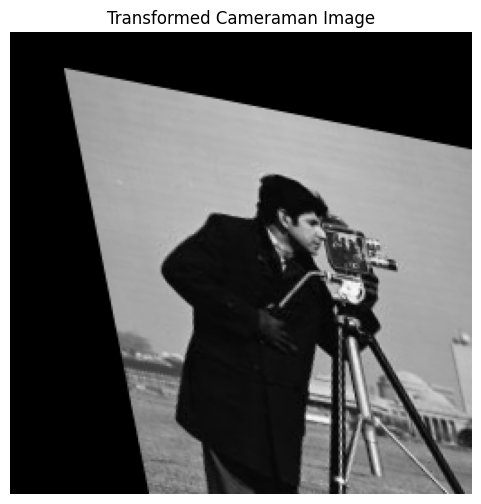

In [6]:
# affine trasnformation
rows, cols = cameraman.shape
M_affine = np.float32([[1, 0.2, 30], [0.2, 1, 20]])
cameraman_transformed = cv2.warpAffine(cameraman, M_affine, (cols, rows))

plt.figure(figsize=(6, 6))
plt.imshow(cameraman_transformed, cmap='gray')
plt.title('Transformed Cameraman Image')
plt.axis('off')
plt.show()


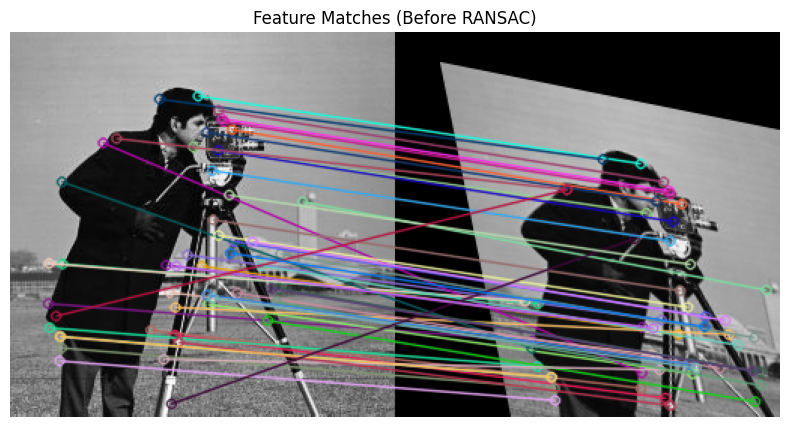

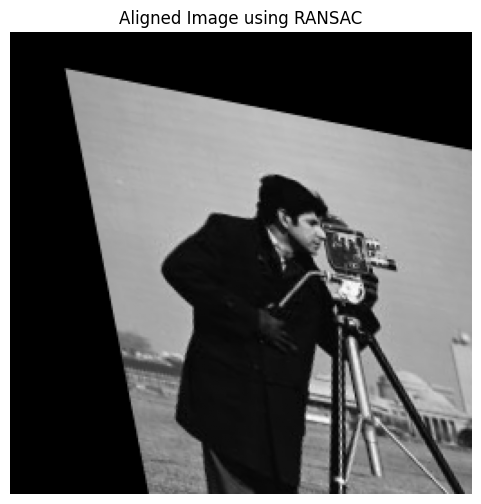

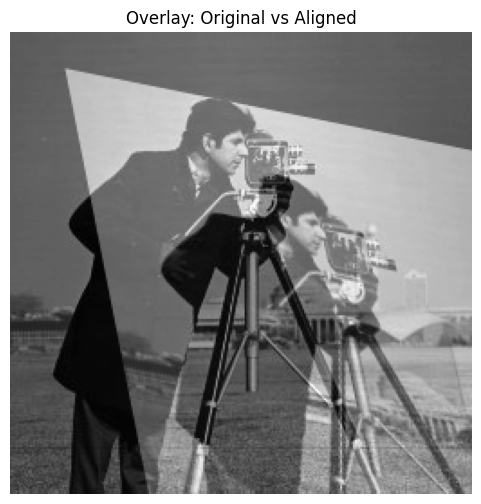

Homography Matrix:
[[ 9.94201463e-01  1.93980180e-01  3.06138690e+01]
 [ 2.00112966e-01  9.90463669e-01  2.02938971e+01]
 [-1.04374542e-06 -3.48275657e-05  1.00000000e+00]]
Number of matched keypoints: 139


In [9]:
### Part C: Image Alignment using RANSAC ###
#converted images to color,used BFMatcher to feature match,
#sorted the matches by distance, extracted the good ones
#homography using RANSAC, warp

def ransac_image_alignment(img1, img2):
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)

    matches = sorted(matches, key=lambda x: x.distance)

    matched_img = cv2.drawMatches(img1_color, kp1, img2_color, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.imshow(matched_img)
    plt.title('Feature Matches (Before RANSAC)')
    plt.axis('off')
    plt.show()

    if len(matches) > 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w = img1.shape
        aligned_img = cv2.warpPerspective(img1, M, (w, h))

        return aligned_img, matches, M
    else:
        print("Not enough matches found!")
        return None, [], None

#RANSAC-based alignment
aligned_image, matches, homography_matrix = ransac_image_alignment(cameraman, cameraman_transformed)

if aligned_image is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(aligned_image, cmap='gray')
    plt.title('Aligned Image using RANSAC')
    plt.axis('off')
    plt.show()

#Overlay original and aligned images
#Printed homography matrix and number of matches

    overlay = cv2.addWeighted(cameraman, 0.5, aligned_image, 0.5, 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay, cmap='gray')
    plt.title('Overlay: Original vs Aligned')
    plt.axis('off')
    plt.show()

print(f"Homography Matrix:\n{homography_matrix}")
print(f"Number of matched keypoints: {len(matches)}")
